In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import os
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [3]:
pca = PCA(n_components=2)
df = pd.read_csv('../data/all_data.csv')
df = df.drop(columns='transit_stations_percent_change_from_baseline')
df = df.dropna()
#df['department_name'] = df['department_name'].apply(lambda x: " ".join(x.split(' ')[:-1]))
X_transformed = pca.fit_transform(df[df.columns[np.r_[1:6]]])
df['component_1'] = X_transformed[:,0]
df['component_2'] = X_transformed[:,1]
df['intercept'] = 1

In [4]:
dept_names = df.department_name.unique()

df['incidents'] = df['incidents'].astype(theano.config.floatX)
dept_idxs, depts = pd.factorize(df.department_name)
coords = {
    "dept": depts,
    "obs_id": np.arange(len(dept_idxs)),
}

with pm.Model(coords=coords) as hierarchical_model:
    dept_idx = pm.Data('dept_indx', dept_idxs, dims="obs_id")

    mu_beta_0 = pm.Normal("mu_beta_0", mu=0.0, sigma=1e9)
    sigma_squared_beta_0 = pm.InverseGamma('sigma_squared_beta_0',alpha=0.5, beta=0.5)
    
    mu_beta_1 = pm.Normal("mu_beta_1", mu=0.0, sigma=1e9)
    sigma_squared_beta_1 = pm.InverseGamma('sigma_squared_beta_1',alpha=0.5, beta=0.5)
    
    mu_beta_2 = pm.Normal("mu_beta_2", mu=0.0, sigma=1e9)
    sigma_squared_beta_2 = pm.InverseGamma('sigma_squared_beta_2',alpha=0.5, beta=0.5)
    
    beta_0 = pm.Normal("beta_0", mu=mu_beta_0, sigma=np.sqrt(sigma_squared_beta_0), dims="dept")
    beta_1 = pm.Normal("beta_1", mu=mu_beta_1, sigma=np.sqrt(sigma_squared_beta_1), dims="dept")
    beta_2 = pm.Normal("beta_2", mu=mu_beta_2, sigma=np.sqrt(sigma_squared_beta_2), dims="dept")
    
    eps = pm.Uniform("eps", lower=0.0, upper=10000, dims='dept')

    mean = beta_0[dept_idx] + beta_1[dept_idx] * df['component_1'] + beta_2[dept_idx] * df['component_2']

    # Data likelihood
    data_like = pm.Normal(
        "data_like", mu=mean, sigma=eps[dept_idx], observed=df['incidents'], dims="obs_id"
    )
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_86826/2265645328.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_2, beta_1, beta_0, sigma_squared_beta_2, mu_beta_2, sigma_squared_beta_1, mu_beta_1, sigma_squared_beta_0, mu_beta_0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 99 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


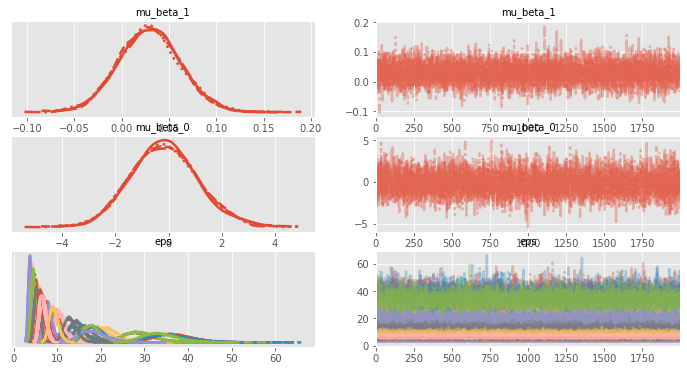

In [5]:
az.plot_trace(hierarchical_trace, var_names=['mu_beta_1', 'mu_beta_0','eps']);

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


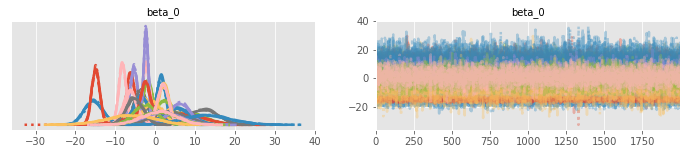

In [6]:
az.plot_trace(hierarchical_trace, var_names=["beta_0"], coords={"dept": dept_names});

In [ ]:
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts, y_depts = [], []
pca = PCA(n_components=2)
time_vecs = []
date_vecs = []
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=5000, burn=1000)
gb.fit()

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3642/5000 [00:46<00:17, 77.45it/s]

In [ ]:
betas_ols = np.zeros([42, 3])
for n, dept in enumerate(groups):
    X, y = X_depts[n][:,1:], y_depts[n]
    reg = LinearRegression()
    reg.fit(X, y)
    betas_ols[n, :] = np.vstack([reg.intercept_,reg.coef_.reshape(-1,1)]).flatten()

In [ ]:
plt.figure(figsize=(15,11))
for i in range(len(groups)):
    plt.subplot(6,7,i+1)
    plt.hist(hierarchical_trace.get_values('beta_2')[:,i], density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['betas'][:,2,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    plt.yticks([])
    plt.xticks(fontsize=10)
   # plt.axvline(x=betas_ols[i,1])
    
    if i == 0:
        plt.legend(loc=(0,1.2), ncol=2)
plt.tight_layout()
plt.savefig('../writeup/compare_gibbs_pymc2.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(7,10))
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist(hierarchical_trace.get_values(f'mu_beta_{i}'), density=True,  bins=100, alpha=.5)
    plt.hist(gb.traces['mu'][:,i], density=True,  bins=100, alpha=.5)
    plt.xticks(fontsize=10)
    plt.yticks([])
    string = str(i) + str(i)
    plt.title(fr'$\mu_{i}$')
    plt.subplot(3,2,2*i+2)
    plt.hist(hierarchical_trace.get_values(f'sigma_squared_beta_{i}'), density=True,  bins=100, alpha=.5, label='PyMC')
    plt.hist(gb.traces['sigmas_diag'][:,i], density=True,  bins=100, alpha=.5, label='Gibbs sampling')
    if i ==0:
        plt.legend(loc=(-1.2,1.2), ncol=2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    tot_string = ('$\Sigma_' + '{' + string + '}$')
    plt.title(tot_string)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('../writeup/compare_gibbs_pymc1.png', dpi=300, bbox_inches='tight')
    

In [ ]:
plt.figure(figsize=(7,10))
means_g = gb.traces['mu'].mean(axis=0)
diag_cov_g = gb.traces['sigmas_diag'].mean(axis=0)
means_p = [hierarchical_trace.get_values(f'mu_beta_{i}').mean() for i in range(3)]
diag_cov_p = [hierarchical_trace.get_values(f'sigma_squared_beta_{i}').mean() for i in range(3)]


from scipy.stats import norm
for i in range(3):
    plt.subplot(3,1,i+1)
    dist = norm(loc=means_g[i], scale=diag_cov_g[i])
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='gibbs')
    
    dist = norm(loc=means_p[i], scale=diag_cov_p[i])
    x = np.linspace(dist.ppf(0.001),dist.ppf(0.999),100)
    plt.plot(x, dist.pdf(x), label='pymc')
    plt.hist(betas_ols[:, i], alpha=.5, bins=20,density=True)
    plt.legend()